In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

batch_size = 4
num_workers = int(os.cpu_count() / 2)
data_folder = '../../data/cifar'


device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepochs = 10

# DT

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trdt = torchvision.datasets.CIFAR10(root=data_folder, train=True,
                                        download=True, transform=transform)

tedt = torchvision.datasets.CIFAR10(root=data_folder, train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trdt, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

testloader = torch.utils.data.DataLoader(tedt, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Net 

In [6]:
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import pickle
import torch
import os

# Define Model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv0   = nn.Conv2d    (   3,  8,   kernel_size=(3, 3),     bias=False  , padding=1)   
        self.max0    = nn.MaxPool2d (            kernel_size=(2,2)                   )   
        self.conv1   = nn.Conv2d    (   8,  16,  kernel_size=(3, 3),     bias=False , padding=1 )   
        self.max1    = nn.MaxPool2d (            kernel_size=(2,2)                   )   
        self.flat    = nn.Flatten   (                                                )   
        self.linear0 = nn.Linear    (            1024,  512                           )
        self.linear1 = nn.Linear    (            512,  10                            )
        self.soft    = nn.Softmax   (            dim=1                               )
        
        self.debug=False
        

    def forward(self,x):
        x_conv0      = self.conv0     (   x              )  
        x_max0       = self.max0      (   x_conv0        )
        x_conv1      = self.conv1     (   x_max0         )  
        x_max1       = self.max1      (   x_conv1        )
        x_flat       = self.flat      (   x_max1         )
        x_linear0    = self.linear0   (   x_flat         )
        x_linear1    = self.linear1   (   x_linear0      )
        x_prob       = self.soft      (   x_linear1      )

            
        return x_prob

# Initialize model and print

model = SimpleNet()


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(nepochs):  # loop over the dataset multiple times
    model.to(device)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


[1,  2000] loss: 2.246
[1,  4000] loss: 2.161
[1,  6000] loss: 2.126
[1,  8000] loss: 2.101
[1, 10000] loss: 2.077
[1, 12000] loss: 2.066
[2,  2000] loss: 2.063
[2,  4000] loss: 2.050
[2,  6000] loss: 2.033
[2,  8000] loss: 2.028
[2, 10000] loss: 2.040
[2, 12000] loss: 2.033
[3,  2000] loss: 2.018
[3,  4000] loss: 2.006
[3,  6000] loss: 2.015
[3,  8000] loss: 2.015
[3, 10000] loss: 2.001
[3, 12000] loss: 2.004
[4,  2000] loss: 2.002
[4,  4000] loss: 1.981
[4,  6000] loss: 1.991
[4,  8000] loss: 1.990
[4, 10000] loss: 1.964
[4, 12000] loss: 1.981
[5,  2000] loss: 1.964
[5,  4000] loss: 1.957
[5,  6000] loss: 1.975
[5,  8000] loss: 1.959
[5, 10000] loss: 1.964
[5, 12000] loss: 1.965
[6,  2000] loss: 1.951
[6,  4000] loss: 1.937
[6,  6000] loss: 1.935
[6,  8000] loss: 1.938
[6, 10000] loss: 1.949
[6, 12000] loss: 1.944
[7,  2000] loss: 1.925
[7,  4000] loss: 1.933
[7,  6000] loss: 1.930
[7,  8000] loss: 1.921
[7, 10000] loss: 1.921
[7, 12000] loss: 1.931
[8,  2000] loss: 1.919
[8,  4000] 

# Display 

In [12]:
model_path = './weights/cifar_torch_simple_10epoch_1.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
model = SimpleNet()
model.load_state_dict(torch.load(model_path))

In [13]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

data_folder = '../../data/cifar'

tedt = datasets.CIFAR10(
    root=data_folder,
    train=False,
    download=True,
    transform=ToTensor(),
)

tedl = DataLoader(tedt, batch_size=4)

teit = iter(tedl)

Files already downloaded and verified


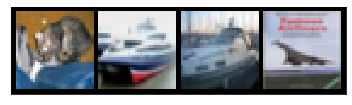

In [14]:
x,y = next(teit)
# draw samples
from torchvision.utils import make_grid
from utils import show
show(make_grid(x))

In [17]:
# predict
x = x.to(device)
model.to(device)

pre = model(x)

pre_arg = pre.argmax(1)

print(f'GT: {y.tolist()}  \n Pre: {pre_arg.tolist()}')
print(f'GT: {[tedt.classes[i] for i in y]} \n Pre: {[tedt.classes[i] for i in pre_arg]}')

GT: [3, 8, 8, 0]  
 Pre: [3, 0, 5, 0]
GT: ['cat', 'ship', 'ship', 'airplane'] 
 Pre: ['cat', 'airplane', 'dog', 'airplane']
